# Udacity Deep Learning Project - Digit Localizer - Part 1

Author: Lei Mao <br>
Late revised on: 1/10/2016 <br>

Notes: Prepare SVHN dataset for digit bounding box regression. To reduce dimensionality, I think it is better to make bounding box that cover all the digits in the image.

## SVHN_BB Dataset Preparation

### Import libraries quired

In [197]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import tarfile
import gzip
import h5py # read .mat files
from scipy import ndimage
from sklearn.model_selection import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [198]:
%autosave 0

Autosave disabled


### Download SVHN dataset

Download SVHN dataset from http://ufldl.stanford.edu/housenumbers/

In [199]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, url, destination_folder, force = False):
    """Download a file if not present, and make sure it's the right size."""
    filename_real = destination_folder + filename
    if force or not os.path.exists(filename_real):
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Attempting to download:', filename) 
        filename_real, _ = urlretrieve(url + filename, filename_real, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename_real)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename_real

In [200]:
url_SVHN = 'http://ufldl.stanford.edu/housenumbers/'
SVHN_folder = 'data/SVHN_BB/'

train_filename = maybe_download(filename = 'train.tar.gz', expected_bytes = 404141560, 
                                url = url_SVHN, destination_folder = SVHN_folder)
test_filename = maybe_download(filename = 'test.tar.gz', expected_bytes = 276555967, 
                               url = url_SVHN, destination_folder = SVHN_folder)
extra_filename = maybe_download(filename = 'extra.tar.gz', expected_bytes = 1955489752, 
                                url = url_SVHN, destination_folder = SVHN_folder)

('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


### Exact SVHN labelset

See http://stackoverflow.com/questions/27670149/read-matlab-v7-3-file-into-python-list-of-numpy-arrays-via-h5py for h5py load and read troubleshooting.

In [201]:
def maybe_extract(filename, dest_folder, force = False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(path = dest_folder)
        tar.close()
    return root + '/'

In [202]:
train_folders = maybe_extract(filename = train_filename, dest_folder = SVHN_folder)
test_folders = maybe_extract(filename = test_filename, dest_folder = SVHN_folder)
extra_folders = maybe_extract(filename = extra_filename, dest_folder = SVHN_folder)

data/SVHN_BB/train already present - Skipping extraction of data/SVHN_BB/train.tar.gz.
data/SVHN_BB/test already present - Skipping extraction of data/SVHN_BB/test.tar.gz.
data/SVHN_BB/extra already present - Skipping extraction of data/SVHN_BB/extra.tar.gz.


In [203]:
def array2string(array):
    string = ''
    for i in array:
        string += chr(i)
    return string

In [204]:
def get_name(fhand, index):
    '''Get the name of indexed image from h5py loaded mat files'''
    '''The return is a string'''
    image_name = fhand[fhand['digitStruct']['name'][index][0]].value
    image_name = image_name.reshape(len(image_name))
    image_name = array2string(image_name)
    return image_name

def get_attribute(fhand, index, attribute):
    '''Get the attribute of indexed image from h5py loaded mat files'''
    '''The return is one-dimensional numpy array'''
    attribute_array = fhand[fhand['digitStruct']['bbox'][index][0]][attribute].value
    attribute_array = attribute_array.reshape(len(attribute_array))
    attribute_list = list()
    if len(attribute_array) <= 1:
        attribute_list = np.array(attribute_array, dtype = np.int)
        return attribute_list
    else:
        for i in attribute_array:
            attribute_list.append(fhand[i].value.reshape(1))
        attribute_list = np.array(attribute_list, dtype = np.int)
        attribute_list = attribute_list.reshape(len(attribute_list))
        return attribute_list

In [205]:
def label_extraction(file_path, numDigits_max, dataformat = 'png'):
    '''Extract label information from 'digitStruct.mat' file using h5py package'''
    with h5py.File(file_path,'r') as f:
        numImages = len(f['digitStruct']['bbox'])
        # Initialize all the attribute matrix to matrix filled with 0
        heights = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        lefts = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        tops = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        widths = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        # The label format according to the introduction of SVHN dataset: 0 - 9 was labeled with 1 - 10 respectively
        # So we can initialize the matrix full of zeros
        labels = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        # Numpy array to store image index
        names = np.zeros(shape = numImages, dtype = int)
        # Count number of warning messages
        warning_count = 0
        print('Processing file: %s...' %(file_path))
        print('This may take a while.')
        for i in xrange(numImages):
            if i % 1000 == 0:
                print('Image labels processed: %d, %.1f%%.' % (i, float(i) / numImages * 100))
            # Get attributes
            height = get_attribute(fhand = f, index = i, attribute = 'height')
            left = get_attribute(fhand = f, index = i, attribute = 'left')
            top = get_attribute(fhand = f, index = i, attribute = 'top')
            width = get_attribute(fhand = f, index = i, attribute = 'width')
            label = get_attribute(fhand = f, index = i, attribute = 'label')
            name = get_name(fhand = f, index = i)
            # Routine check
            if len(height) > numDigits_max:
                print('Warning: number of elements in height exceed numDigits_max assigned.')
                warning_count += 1
            if len(left) > numDigits_max:
                print('Warning: number of elements in left exceed numDigits_max assigned.')
                warning_count += 1
            if len(top) > numDigits_max:
                print('Warning: number of elements in top exceed numDigits_max assigned.')   
                warning_count += 1
            if len(width) > numDigits_max:
                print('Warning: number of elements in width exceed numDigits_max assigned.')
                warning_count += 1
            if len(height) > numDigits_max:
                print('Warning: number of elements in height exceed numDigits_max assigned.') 
                warning_count += 1
            if name.split('.')[1] != dataformat:
                print('Warning: image file name does not end with %s.' % dataformat) 
                warning_count += 1
            # Put attributes to corresponding matrix
            heights[i][0:len(height)] = height
            lefts[i][0:len(left)] = left
            tops[i][0:len(top)] = top
            widths[i][0:len(width)] = width
            labels[i][0:len(label)] = label
            names[i] = int(name.split('.')[0])
            
    if warning_count != 0:
        print('There might be problems during label extraction.')
    print('Label extraction finished.')
    print('Total number of image labels processed: %d.' % numImages)
    
    labelset = {'names': names, 'labels': labels, 'heights': heights, 'lefts': lefts, 'tops': tops, 'widths': widths}
    
    return labelset

In [206]:
def maybe_labelset_pickle(file_path, numDigits_max, set_filename, destination_folder, force = False, dataformat = 'png'):
    '''Store labelset to pickle file'''
    '''labelset has to be in dictionary format'''
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            with open(filename_real, 'wb') as f:
                labelset = label_extraction(
                    file_path = file_path, numDigits_max = numDigits_max, dataformat = dataformat)
                pickle.dump(labelset, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
    return filename_real

In [207]:
labels_filename = 'digitStruct.mat'
numDigits_max = 6

train_labelset_path = maybe_labelset_pickle(file_path = train_folders + labels_filename, numDigits_max = numDigits_max, 
                                            set_filename = 'train_labelset', destination_folder = SVHN_folder, 
                                            force = False, dataformat = 'png')

test_labelset_path = maybe_labelset_pickle(file_path = test_folders + labels_filename, numDigits_max = numDigits_max, 
                                           set_filename = 'test_labelset', destination_folder = SVHN_folder, 
                                           force = False, dataformat = 'png')

extra_labelset_path = maybe_labelset_pickle(file_path = extra_folders + labels_filename, numDigits_max = numDigits_max, 
                                            set_filename = 'extra_labelset', destination_folder = SVHN_folder, 
                                            force = False, dataformat = 'png')

train_labelset.pickle already present - Skipping pickling.
test_labelset.pickle already present - Skipping pickling.
extra_labelset.pickle already present - Skipping pickling.


### Define digit sequence bounding box algorithm

In [208]:
def load_pickle(file_path):
    '''Load data from pickle file'''
    with open(file_path, 'rb') as f:
        save = pickle.load(f)
    return save

In [209]:
train_labelset = load_pickle(train_labelset_path)
test_labelset = load_pickle(test_labelset_path)
extra_labelset = load_pickle(extra_labelset_path)

In [210]:
print('The train_labelset contains:', train_labelset.keys())
print('The test_labelset contains:', test_labelset.keys())
print('The extra_labelset contains:', extra_labelset.keys())

('The train_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])
('The test_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])
('The extra_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])


In [211]:
def bounding_box(image_size, labels, lefts, tops, heights, widths, expansion = 0., seed = 0):
    '''This is an algorithm to select a digit sequence bounding box given the image and single digit bounding box'''
    '''Author: Lei Mao'''
    
    # The algorithm has random process. Include random seed here.
    np.random.seed(seed=seed)
    
    sequence_length = np.sum(labels > 0)
    
    topleft_x = lefts[0: sequence_length]
    topleft_y = tops[0: sequence_length]
    height_elements = heights[0: sequence_length]
    width_elements = widths[0: sequence_length]
    bottomright_x = topleft_x + width_elements
    bottomright_y = topleft_y + height_elements
    
    # Correct the parameters
    for i in xrange(sequence_length):
        if topleft_x[i] < 0:
            topleft_x[i] = 0
        if topleft_y[i] < 0:
            topleft_y[i] = 0
        if bottomright_x[i] > image_size[1] - 1:
            bottomright_x[i] = image_size[1] - 1
        if bottomright_y[i] > image_size[0] - 1:
            bottomright_y[i] = image_size[0] - 1
    
    height_elements = bottomright_y - topleft_y
    width_elements = bottomright_x - topleft_x

    # Find the topleft and bottomright coordinates of the minimal bounding box
    box_min_topleft_x = np.amin(topleft_x)
    box_min_topleft_y = np.amin(topleft_y)
    box_min_bottomright_x = np.amax(bottomright_x)
    box_min_bottomright_y = np.amax(bottomright_y)
    
    # Expand the minimal bounding box by expansion
    box_min_height = box_min_bottomright_y - box_min_topleft_y
    box_min_width = box_min_bottomright_x - box_min_topleft_x
    
    box_expanded_height = int(box_min_height * (1. + expansion))
    box_expanded_width = int(box_min_width * (1. + expansion))
    
    if box_expanded_height >= image_size[0]:
        # After expansion, if the expanded box height is larger than the original image height
        # Use the original original image height for the expanded box
        box_expanded_topleft_y = 0
        box_expanded_bottomright_y = image_size[0]
    else:
        '''box_min_topleft_y >= box_expanded_topleft_y >= 0'''
        '''image_size[0] - box_expanded_height >= box_expanded_topleft_y >= box_min_bottomright_y - box_expanded_height'''
        # Randomly select a expanded box that contains the minimal box
        box_expanded_topleft_y = np.random.randint(
            low = np.amax([0, box_min_bottomright_y - box_expanded_height]), 
            high = np.amin([box_min_topleft_y, image_size[0] - box_expanded_height]) + 1)
        box_expanded_bottomright_y = box_expanded_topleft_y + box_expanded_height
    
    if box_expanded_width >= image_size[1]:
        box_expanded_topleft_x = 0
        box_expanded_bottomright_x = image_size[1]       
    else:
        '''box_min_topleft_x >= box_expanded_topleft_x >= 0'''
        '''image_size[1] - box_expanded_width + 1 >= box_expanded_topleft_x >= box_min_bottomright_x - box_expanded_width + 1'''
        box_expanded_topleft_x = np.random.randint(
            low = np.amax([0, box_min_bottomright_x - box_expanded_width]), 
            high = np.amin([box_min_topleft_x, image_size[1] - box_expanded_width]) + 1)
        box_expanded_bottomright_x = box_expanded_topleft_x + box_expanded_width
    return (box_expanded_topleft_x, box_expanded_topleft_y), (box_expanded_bottomright_x, box_expanded_bottomright_y)

In [212]:
def bounding_box_test(labelset, dataset_path, image_index, expansion = 0., seed = 0):
    '''Test the bounding box algorithm in training dataset'''
    image_path = dataset_path + str(image_index + 1) + '.png'
    img = cv2.imread(image_path)
    # Plot single digit bounding box
    sequence_length = np.sum(labelset['labels'][image_index] > 0)
    topleft_x = labelset['lefts'][image_index][0: sequence_length]
    topleft_y = labelset['tops'][image_index][0: sequence_length]
    height_elements = labelset['heights'][image_index][0: sequence_length]
    width_elements = labelset['widths'][image_index][0: sequence_length]
    bottomright_x = topleft_x + width_elements
    bottomright_y = topleft_y + height_elements
    # Plot single digit bounding box
    for i in xrange(len(topleft_x)):
        cv2.rectangle(img, (topleft_x[i], topleft_y[i]), (bottomright_x[i], bottomright_y[i]), (255,0,0), 1)
    # Plot expanded digit sequence bounding box
    topleft, bottomright = bounding_box(image_size = img.shape, labels = labelset['labels'][image_index], 
                                        lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                                        heights = labelset['heights'][image_index], 
                                        widths = labelset['widths'][image_index], expansion = expansion, seed = seed)
    cv2.rectangle(img, topleft, bottomright, (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img)
    plt.show()

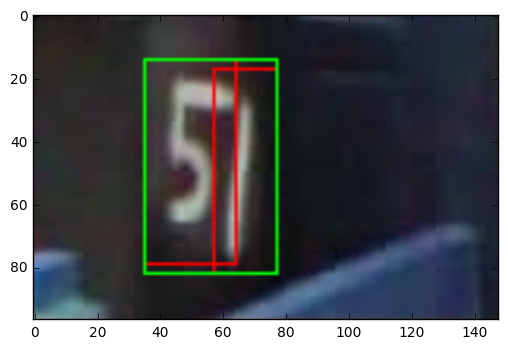

In [213]:
bounding_box_test(labelset = test_labelset, dataset_path = SVHN_folder + 'test/', 
                  image_index = 30, expansion = 0., seed = 3)

### Define bounding box resize algorithm

To prepare the SVHN dataset for bounding box regression. The image size requires to be the same throughout the dataset. Therefore, the images and bounding box parameters in the dataset need to be resized or recalculated.

Suppose the original image size was m x n and the image was resized to m' x n'. If the original bounding box parameters was in format (left, top, width, height) (x, y, w, h), the recalculated bounding box parameters became ((n'/n)x, (m'/m)y, (n'/n)w, (m'/m)h). If the original bounding box parameters was in format (topleft_x, topleft_y, bottomright_x, bottomright_y) (x1, y1, x2, y2), the recalculated bounding box parameters became ((n'/n)x1, (m'/m)y1, (n'/n)x2, (m'/m)y2). To describe the transformation in matrix multiplication, L x [n'/n, m'/m, n'/n, m'/m]' = L'.

In this case, I choose to use (topleft_x, topleft_y, bottomright_x, bottomright_y) format. The reason is a little bit complicated. To train a digit localizer, we have to prepare image dataset of the same image size. This means that we have to resize the image and also recalculate the bounding box parameters. After training, we also need to calculate back the recovered bounding box parameters from the bounding box parameters in the resized image. There is likely to be information loss during these steps and the position of bounding box might not be accurate if calculate back. I found (topleft_x, topleft_y, bottomright_x, bottomright_y) format can minimize the loss of bounding box accuracy by set rounding to floor during topleft_x and topleft_y calculation and set rounding to ceil during bottomright_x and bottomright_y. In this way, the bounding box after recovery could at least still contain the original digits. For (left, top, width, height) format, we could also perform the same method. However, for the accuracy, because the other three corners of the bounding box are dependent on left/width or top/height, there might be bounding box accuracy loss at the other three corners.

If you are interested in seeing the difference that I mentioned above. You may check the last part of this note book.

In [214]:
def bbox_resize(img, bbox_label, size):
    ''' This is a function to calculate the bounding box parameters after image size.
    img: np.ndarry of img
    bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]
    size: size of image after resize'''

    img_resized = cv2.resize(img, (size, size))
    img_resized = img_resized.copy()
    multiplier = np.array([float(size)/img.shape[1], float(size)/img.shape[0], float(size)/img.shape[1], float(size)/img.shape[0]])
    
    topleft_x_resized = np.floor(bbox_label[0] * multiplier[0])
    topleft_y_resized = np.floor(bbox_label[1] * multiplier[1])
    bottomright_x_resized = np.ceil(bbox_label[2] * multiplier[2])
    bottomright_y_resized = np.ceil(bbox_label[3] * multiplier[3])
 
    bbox_label_resized = np.int32([topleft_x_resized, topleft_y_resized, bottomright_x_resized, bottomright_y_resized])
    return bbox_label_resized

In [215]:
def bbox_recover(img, bbox_label, size):
    '''This is a function to calculate the bounding box after image size recovery.
    img: np.ndarry of img
    bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]
    size: size of image after resize'''
    multiplier = np.array([float(img.shape[1])/size, float(img.shape[0])/size, float(img.shape[1])/size, float(img.shape[0])/size])
    
    topleft_x_recovered = np.floor(bbox_label[0] * multiplier[0])
    topleft_y_recovered = np.floor(bbox_label[1] * multiplier[1])
    bottomright_x_recovered = np.ceil(bbox_label[2] * multiplier[2])
    bottomright_y_recovered = np.ceil(bbox_label[3] * multiplier[3])
    
    bbox_label_recovered = np.int32([topleft_x_recovered, topleft_y_recovered, bottomright_x_recovered, bottomright_y_recovered])
    return bbox_label_recovered

In [216]:
def bbox_show(img, bbox_label, show = True):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    img_data = img.copy()
    if show == True:
        cv2.rectangle(img_data, (bbox_label[0], bbox_label[1]), (bbox_label[2], bbox_label[3]), (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

Bounding box calculation - [topleft_x, topleft_y, bottomright_x, bottomright_y] format.
Bounding box before resize.


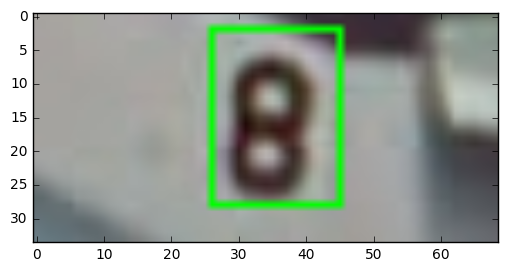

Bounding box after resize.


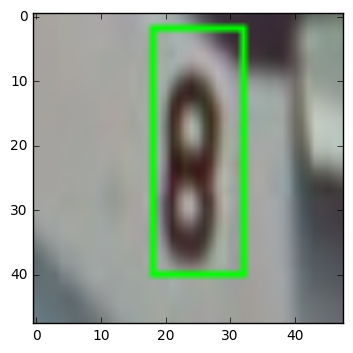

Bounding box after recover.


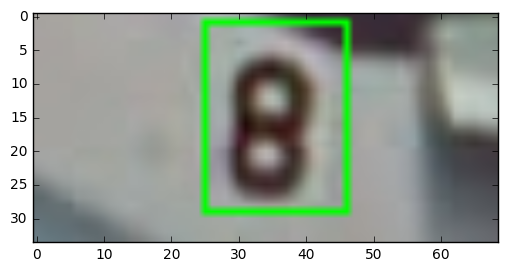

In [217]:
print('Bounding box calculation - [topleft_x, topleft_y, bottomright_x, bottomright_y] format.')
labelset = test_labelset
#image_index = np.random.randint(len(labelset))
image_index = 889
image_path = SVHN_folder + 'test/' + str(image_index + 1) + '.png'
img_data = cv2.imread(image_path)
# Show bounding box before resize
print('Bounding box before resize.')
bbox_param = bounding_box(image_size = img_data.shape, labels = labelset['labels'][image_index], 
                          lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                          heights = labelset['heights'][image_index], widths = labelset['widths'][image_index], 
                          expansion = 0, seed = 0)
bbox_label = np.int32([bbox_param[0][0], bbox_param[0][1], bbox_param[1][0], bbox_param[1][1]])
# Show bounding box before resize
img_data_copy = img_data.copy()
bbox_show(img_data_copy, bbox_label)

# Show bounding box after resize
print('Bounding box after resize.')
size = 48
bbox_label_resized = bbox_resize(img_data, bbox_label = bbox_label, size = size)
img_resized = cv2.resize(img_data, (size, size))
img_resized_copy = img_resized.copy()
bbox_show(img_resized_copy, bbox_label_resized)

# Show bounding box after recover
print('Bounding box after recover.')
img_data_copy = img_data.copy()
bbox_label_recover = bbox_recover(img_data_copy, bbox_label = bbox_label_resized, size = size)
bbox_show(img_data_copy, bbox_label_recover)

### Comparison of bounding box calculation

In [218]:
def bbox_resize_2(img, bbox_param, size):
    ''' This is a function to calculate the bounding box parameters after image size.
    img: np.ndarry of img
    bbox_param: ((topleft_x, topleft_y), (bottomright_x, bottomright_y))
    size: size of image after resize'''
    topleft = bbox_param[0]
    bottomright = bbox_param[1]
    # Change the bbox_param format to (top, left, width, height) format
    bbox_label = np.array([topleft[0], topleft[1], bottomright[0] - topleft[0], bottomright[1] - topleft[1]])
    img_resized = cv2.resize(img, (size, size))
    img_resized = img_resized.copy()
    multiplier = np.array([float(size)/img.shape[1], float(size)/img.shape[0], float(size)/img.shape[1], float(size)/img.shape[0]])
    
    left_resized = np.floor(bbox_label[0] * multiplier[0])
    top_resized = np.floor(bbox_label[1] * multiplier[1])
    width_resized = np.ceil(bbox_label[2] * multiplier[2])
    height_resized = np.ceil(bbox_label[3] * multiplier[3])
 
    bbox_label_resized = np.int32([left_resized, top_resized, width_resized, height_resized])
    return bbox_label_resized

In [219]:
def bbox_recover_2(img, bbox_label, size):
    '''This is a function to calculate the bounding box after image size recovery.
    img: np.ndarry of img
    bbox_param: [left, top, width, height]
    size: size of image after resize'''
    multiplier = np.array([float(img.shape[1])/size, float(img.shape[0])/size, float(img.shape[1])/size, float(img.shape[0])/size])
    
    left_recovered = np.floor(bbox_label[0] * multiplier[0])
    top_recovered = np.floor(bbox_label[1] * multiplier[1])
    width_recovered = np.ceil(bbox_label[2] * multiplier[2])
    height_recovered = np.ceil(bbox_label[3] * multiplier[3])
    
    bbox_label_recovered = np.int32([left_recovered, top_recovered, width_recovered, height_recovered])
    return bbox_label_recovered

In [220]:
def bbox_show_2(img, bbox_param):
    '''bbox_param: (top, left, width, height)'''
    img_data = img.copy()
    cv2.rectangle(img_data, (bbox_param[0], bbox_param[1]), (bbox_param[0] + bbox_param[2], bbox_param[1] + bbox_param[3]), (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img_data)
    plt.show()
    return

Bounding box calculation - [left, top, width, height] format.
Bounding box before resize.


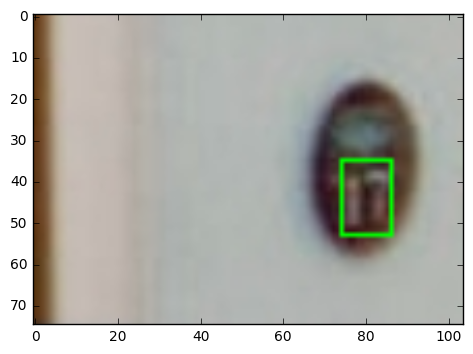

Bounding box after resize.


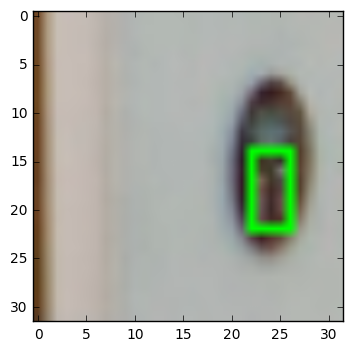

Bounding box after recover.


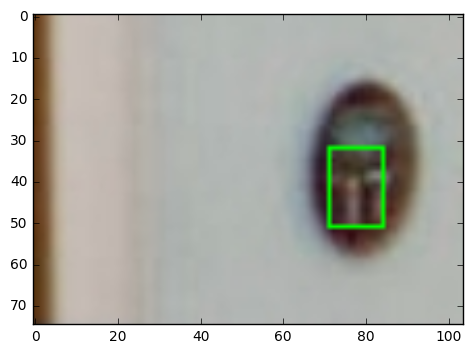

In [221]:
print('Bounding box calculation - [left, top, width, height] format.')
image_index = 3016
image_path = SVHN_folder + 'test/' + str(image_index + 1) + '.png'
img_data = cv2.imread(image_path)

bbox_param = bounding_box(image_size = img_data.shape, labels = labelset['labels'][image_index], 
                          lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                          heights = labelset['heights'][image_index], widths = labelset['widths'][image_index], 
                          expansion = 0, seed = 0)
# Show bounding box before resize
print('Bounding box before resize.')
img_data_copy = img_data.copy()
cv2.rectangle(img_data_copy, bbox_param[0], bbox_param[1], (0,255,0), 1)
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(img_data_copy)
plt.show()

# Show bounding box after resize
print('Bounding box after resize.')
size = 32
bbox_label_resized = bbox_resize_2(img_data, bbox_param = bbox_param, size = size)
img_resized = cv2.resize(img_data, (size, size))
img_resized_copy = img_resized.copy()
bbox_show_2(img_resized_copy, bbox_label_resized)

# Show bounding box after recover
print('Bounding box after recover.')
img_data_copy = img_data.copy()
bbox_label_recover = bbox_recover_2(img_data_copy, bbox_label = bbox_label_resized, size = size)
bbox_show_2(img_data_copy, bbox_label_recover)

### Resize SVHN images and recalculate the bounding box

I found most of the bounding boxes are located around the center of the image. This will cause biase in the training dataset. The neural network will likely to learn a localizer at the center of the image without generalizing to the corner of the image.

Therefore, I need to crop the image and generate several versions of the image containing the bounding box whose locations are more likely to be evenly distributed.

The algorithm is simple, to make the bounding box shift left, I simply randomly crop the image left to the bounding box. Similarly, to make the bounding box shift right, just crop the image right to tbe bounding box. To make the bounding box shift down, crop the image down to the bounding box. To make the bounding box shift up, crop the image up to the bounding box. Choosing the topleft corner coordinates of the image may achieve the combination of shift top left. Choosing the bottomright corner coordinates of the image may achieve the combination of shift bottom right. etc.

Here I am going to generate 8 shifts for the bounding box: up, down, left, right, top left, bottom left, top right, bottom right.

In [156]:
def image_crop(img, bbox_label):
    '''bbox_label: [topleft_x, topleft_y, bottomright_x, bottomright_y]'''
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    # Put the crop parameters and recalculated bounding box labels into the list
    cropped_coordinates = [[0, 0, img.shape[1] - 1, img.shape[0] - 1]]
    bbox_coordinates = [list(bbox_label)]
    # Left
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([topleft_x_cropped, 0, img.shape[1] - 1, img.shape[0] - 1])
    bbox_coordinates.append([bbox_label[0] - topleft_x_cropped, bbox_label[1], bbox_label[2] - topleft_x_cropped, bbox_label[3]])
    # Right
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([0, 0, bottomright_x_cropped, img.shape[0] - 1])
    bbox_coordinates.append(list(bbox_label))
    # Top
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([0, topleft_y_cropped, img.shape[1] - 1, img.shape[0] - 1])
    bbox_coordinates.append([bbox_label[0], bbox_label[1] - topleft_y_cropped, bbox_label[2], bbox_label[3] - topleft_y_cropped])
    # Bottom
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([0, 0, img.shape[1] - 1, bottomright_y_cropped])
    bbox_coordinates.append(list(bbox_label))
    # Top left
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([topleft_x_cropped, topleft_y_cropped, img.shape[1] - 1, img.shape[0] - 1])
    bbox_coordinates.append([bbox_label[0] - topleft_x_cropped, bbox_label[1] - topleft_y_cropped, bbox_label[2] - topleft_x_cropped, bbox_label[3] - topleft_y_cropped])
    # Top right
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([0, topleft_y_cropped, bottomright_x_cropped, img.shape[0] - 1])
    bbox_coordinates.append([bbox_label[0], bbox_label[1] - topleft_y_cropped, bbox_label[2], bbox_label[3] - topleft_y_cropped])
    # Bottom left
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([topleft_x_cropped, 0, img.shape[1] - 1, bottomright_y_cropped])
    bbox_coordinates.append([bbox_label[0] - topleft_x_cropped, bbox_label[1], bbox_label[2] - topleft_x_cropped, bbox_label[3]])
    # Bottom right
    topleft_x_cropped = np.random.randint(bbox_label[0] + 1)
    topleft_y_cropped = np.random.randint(bbox_label[1] + 1)
    bottomright_x_cropped = np.random.randint(low = bbox_label[2], high = img.shape[1]) 
    bottomright_y_cropped = np.random.randint(low = bbox_label[3], high = img.shape[0]) 
    
    cropped_coordinates.append([0, 0, bottomright_x_cropped, bottomright_y_cropped])
    bbox_coordinates.append(list(bbox_label))
    
    return cropped_coordinates, bbox_coordinates

Test the image crop and bounding box shift function

Bounding box before resize.


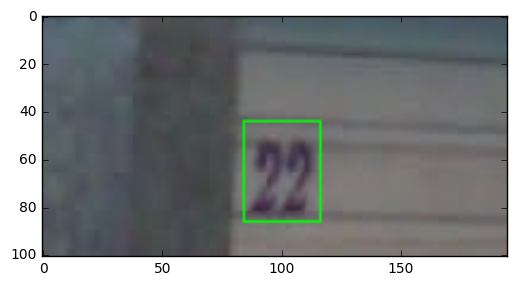

Bounding box after resize.


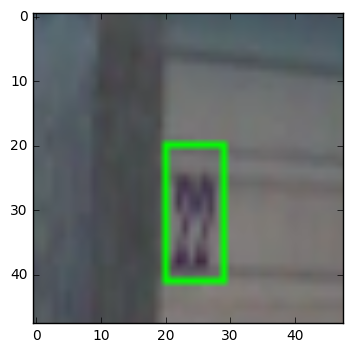

Bounding box before resize.


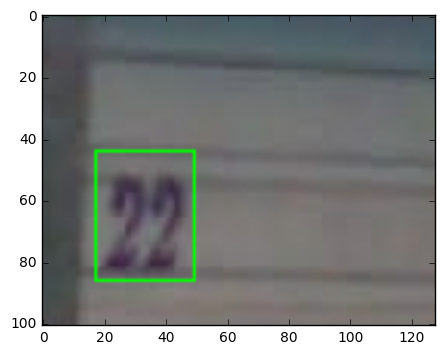

Bounding box after resize.


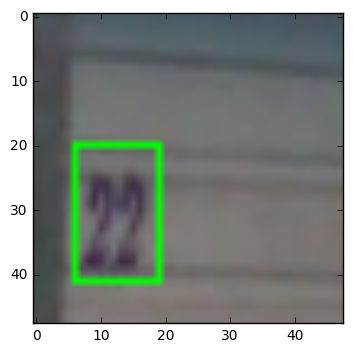

Bounding box before resize.


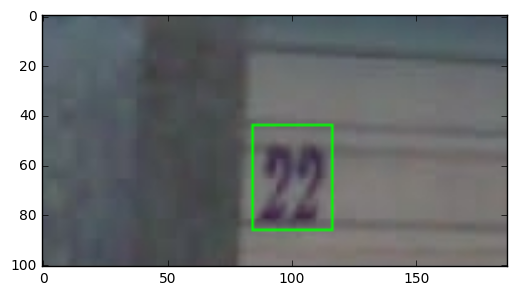

Bounding box after resize.


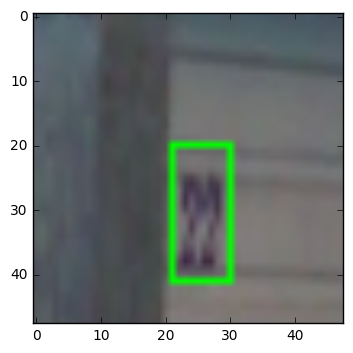

Bounding box before resize.


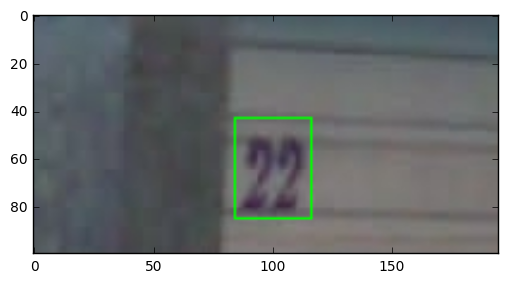

Bounding box after resize.


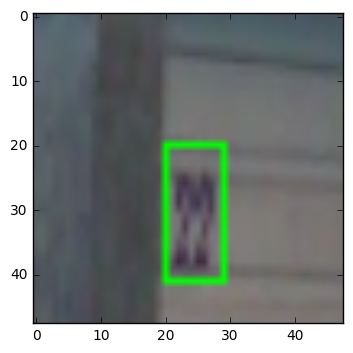

Bounding box before resize.


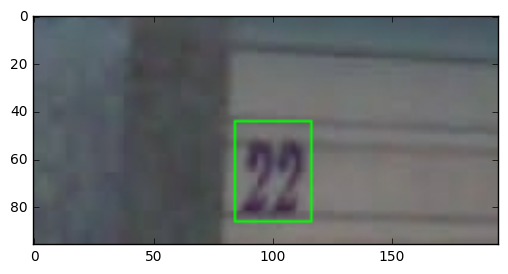

Bounding box after resize.


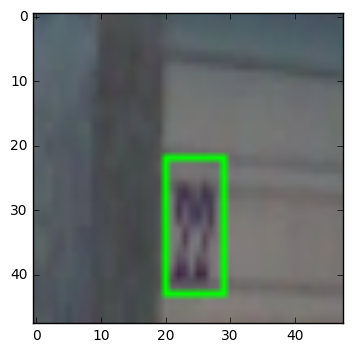

Bounding box before resize.


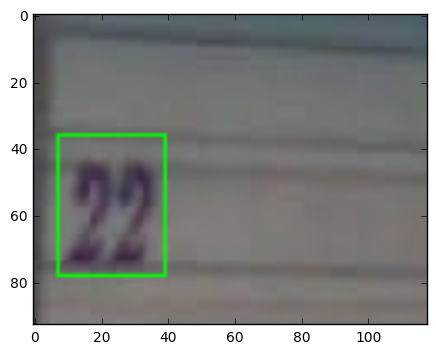

Bounding box after resize.


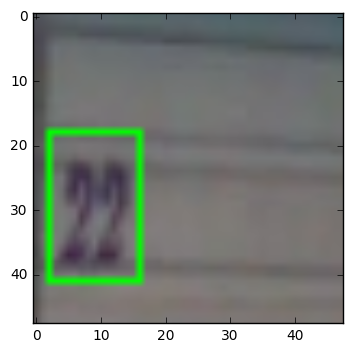

Bounding box before resize.


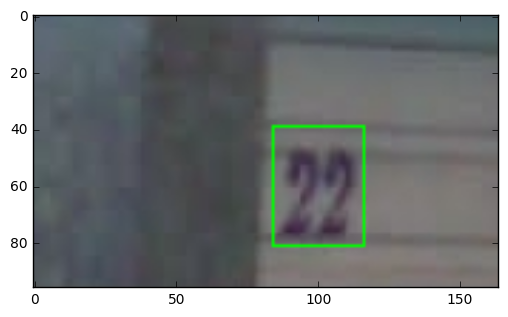

Bounding box after resize.


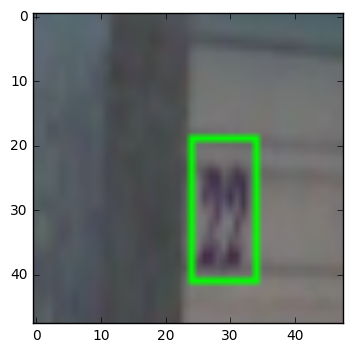

Bounding box before resize.


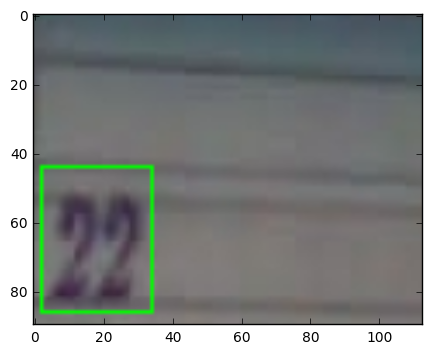

Bounding box after resize.


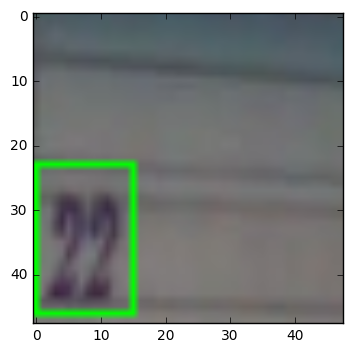

Bounding box before resize.


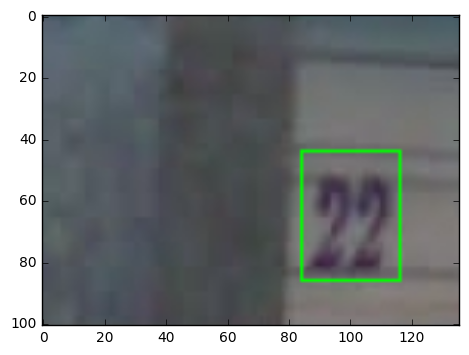

Bounding box after resize.


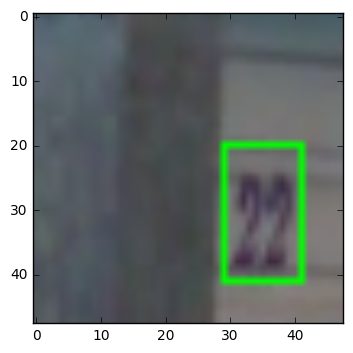

In [157]:
labelset = test_labelset
#image_index = np.random.randint(len(labelset))
image_index = 1199
image_path = SVHN_folder + 'test/' + str(image_index + 1) + '.png'
img_data = cv2.imread(image_path)

bbox_param = bounding_box(image_size = img_data.shape, labels = labelset['labels'][image_index], 
                          lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                          heights = labelset['heights'][image_index], widths = labelset['widths'][image_index], 
                          expansion = 0, seed = 0)
bbox_label = np.int32([bbox_param[0][0], bbox_param[0][1], bbox_param[1][0], bbox_param[1][1]])
# Calculated cropped image and shifted bounding box
cropped_coordinates, bbox_coordinates = image_crop(img = img_data, bbox_label = bbox_label)

for crop, bbox in zip(cropped_coordinates, bbox_coordinates):
    print('Bounding box before resize.')
    img_cropped = img_data[crop[1]:(crop[3]+1), crop[0]:(crop[2]+1)]
    bbox_show(img_cropped, bbox_label = bbox)
    # Show bounding box after resize
    print('Bounding box after resize.')
    size = 48
    bbox_label_resized = bbox_resize(img_cropped, bbox_label = bbox, size = size)
    img_resized = cv2.resize(img_cropped, (size, size))
    img_resized_copy = img_resized.copy()
    bbox_show(img_resized_copy, bbox_label_resized)

In [158]:
def image_preprocessing(labelset, dataset_path, size = 32, num_channels = 3, shift = False):
    '''This image preprocessing contains several steps: 
    1. Define certain numbers of sequence bounding box that contains all the digits in the image;
    2. Resize the image to square with certain size.'''
    
    if shift == True:
        num_images = len(labelset['names']) * 9
    else:
        num_images = len(labelset['names'])
        
    # Notes: OpenCV rectangle function has bugs. 
    # If the datatype is not uint8, the cv2.rectangle function is not able to plot rectangle. 
    dataset_processed = np.zeros(shape = (num_images, size, size, num_channels), dtype = np.uint8)
    labels_processed = np.zeros(shape = (num_images, 4), dtype = np.int32)
    
    print('Start to preprocess dataset: %s' % dataset_path)
    
    for i in xrange(len(labelset['names'])):
        if i % 1000 == 0:
            print('Image processed: %d, %.1f%%.' % (i, float(i) / len(labelset['names']) * 100))

        image_path = dataset_path + str(labelset['names'][i]) + '.png'
        img = cv2.imread(image_path)
        topleft, bottomright = bounding_box(image_size = img.shape, labels = labelset['labels'][i], 
                                            lefts = labelset['lefts'][i], tops = labelset['tops'][i], 
                                            heights = labelset['heights'][i], widths = labelset['widths'][i], 
                                            expansion = 0, seed = 0)
        
        bbox_label = np.array([topleft[0], topleft[1], bottomright[0], bottomright[1]])
        
        if shift == True:
            cropped_coordinates, bbox_coordinates = image_crop(img = img, bbox_label = bbox_label)
            for j, (crop, bbox) in enumerate(zip(cropped_coordinates, bbox_coordinates)):
                img_cropped = img[crop[1]:(crop[3]+1), crop[0]:(crop[2]+1)]
                bbox_label_resized = bbox_resize(img_cropped, bbox_label = bbox, size = size)
                img_resized = cv2.resize(img_cropped, (size, size))
                img_resized = img_resized.copy()
                
                dataset_processed[i * 9 + j] = img_resized
                labels_processed[i * 9 + j] = bbox_label_resized            
            
        else:
            bbox_label_resized = bbox_resize(img, bbox_label = bbox_label, size = size)
            img_resized = cv2.resize(img, (size, size))
            img_resized = img_resized.copy()
            
            dataset_processed[i] = img_resized
            labels_processed[i] = bbox_label_resized
    
    print('Preprocess completed.')
            
    return dataset_processed, labels_processed

In [159]:
def maybe_pickle(dataset, labels, set_filename, destination_folder, force = False):
    '''Store dataset and labels to pickle file'''
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            with open(filename_real, 'wb') as f:
                save = {
                    'dataset': dataset,
                    'labels': labels
                }
                pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
    return filename_real

In [160]:
image_size = 48

train_dataset_processed, train_labels_processed = image_preprocessing(
    labelset = train_labelset, dataset_path = SVHN_folder + 'train/', size = image_size, num_channels = 3, shift = True)

Start to preprocess dataset: data/SVHN_BB/train/
Image processed: 0, 0.0%.
Image processed: 1000, 3.0%.
Image processed: 2000, 6.0%.
Image processed: 3000, 9.0%.
Image processed: 4000, 12.0%.
Image processed: 5000, 15.0%.
Image processed: 6000, 18.0%.
Image processed: 7000, 21.0%.
Image processed: 8000, 24.0%.
Image processed: 9000, 26.9%.
Image processed: 10000, 29.9%.
Image processed: 11000, 32.9%.
Image processed: 12000, 35.9%.
Image processed: 13000, 38.9%.
Image processed: 14000, 41.9%.
Image processed: 15000, 44.9%.
Image processed: 16000, 47.9%.
Image processed: 17000, 50.9%.
Image processed: 18000, 53.9%.
Image processed: 19000, 56.9%.
Image processed: 20000, 59.9%.
Image processed: 21000, 62.9%.
Image processed: 22000, 65.9%.
Image processed: 23000, 68.9%.
Image processed: 24000, 71.9%.
Image processed: 25000, 74.8%.
Image processed: 26000, 77.8%.
Image processed: 27000, 80.8%.
Image processed: 28000, 83.8%.
Image processed: 29000, 86.8%.
Image processed: 30000, 89.8%.
Image p

In [161]:
maybe_pickle(dataset = train_dataset_processed, labels = train_labels_processed, set_filename = 'train_set', 
             destination_folder = SVHN_folder, force = False)

Pickling train_set.
train_set.pickle saved successfully


'data/SVHN_BB/train_set.pickle'

In [162]:
image_size = 48

test_dataset_processed, test_labels_processed = image_preprocessing(
    labelset = test_labelset, dataset_path = SVHN_folder + 'test/', size = image_size, num_channels = 3)

Start to preprocess dataset: data/SVHN_BB/test/
Image processed: 0, 0.0%.
Image processed: 1000, 7.7%.
Image processed: 2000, 15.3%.
Image processed: 3000, 23.0%.
Image processed: 4000, 30.6%.
Image processed: 5000, 38.3%.
Image processed: 6000, 45.9%.
Image processed: 7000, 53.6%.
Image processed: 8000, 61.2%.
Image processed: 9000, 68.9%.
Image processed: 10000, 76.5%.
Image processed: 11000, 84.2%.
Image processed: 12000, 91.8%.
Image processed: 13000, 99.5%.
Preprocess completed.


In [163]:
maybe_pickle(dataset = test_dataset_processed, labels = test_labels_processed, set_filename = 'test_set', 
             destination_folder = SVHN_folder, force = False)

Pickling test_set.
test_set.pickle saved successfully


'data/SVHN_BB/test_set.pickle'

image_size = 48

extra_dataset_processed, extra_labels_processed = image_preprocessing(
    labelset = extra_labelset, dataset_path = SVHN_folder + 'extra/', size = image_size, num_channels = 3)

maybe_pickle(dataset = extra_dataset_processed, labels = extra_labels_processed, set_filename = 'extra_set', 
             destination_folder = SVHN_folder, force = False)

### Extract data and labels from saved files

In [164]:
# Read training datset
SVHN_folder = 'data/SVHN_BB/'
pickle_file = 'train_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    train_dataset = save['dataset']
    train_labels = save['labels']
    del save  # hint to help gc free up memory

    print('SVHN training set', train_dataset.shape, train_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN training set', (300618, 48, 48, 3), (300618, 4))


Bounding box before resize.


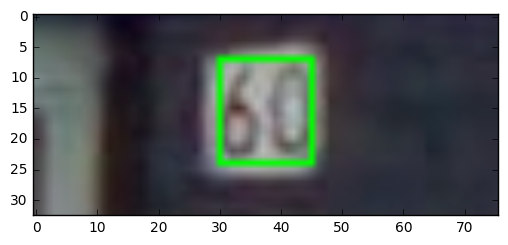

Bounding box after resize.


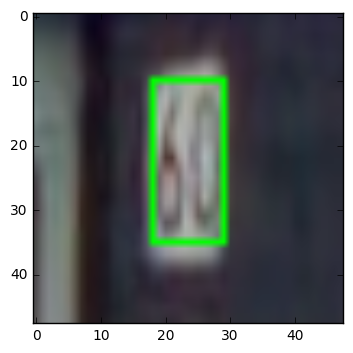

In [171]:
labelset = train_labelset
#image_index = np.random.randint(len(labelset))
image_index = 888
image_path = SVHN_folder + 'train/' + str(image_index + 1) + '.png'
img_data = cv2.imread(image_path)

bbox_param = bounding_box(image_size = img_data.shape, labels = labelset['labels'][image_index], 
                          lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                          heights = labelset['heights'][image_index], widths = labelset['widths'][image_index], 
                          expansion = 0, seed = 0)
bbox_label = np.int32([bbox_param[0][0], bbox_param[0][1], bbox_param[1][0], bbox_param[1][1]])

# Show bounding box before resize
print('Bounding box before resize.')
img_data_copy = img_data.copy()
bbox_show(img_data_copy, bbox_label)

# Show bounding box after resize
print('Bounding box after resize.')
bbox_show(train_dataset[image_index], train_labels[image_index])